In [ ]:
from pulp import *

CS_info = {
    "CS1": {"loc": (1, 2), "Ts": 8, "Te": 20, "α": 50, "Tw": 10, "Cm": 0.2, "Cp": 0.1},
    "CS2": {"loc": (3, 4), "Ts": 10, "Te": 18, "α": 60, "Tw": 15, "Cm": 0.15, "Cp": 0.2},
    "CS3": {"loc": (5, 6), "Ts": 9, "Te": 21, "α": 70, "Tw": 12, "Cm": 0.18, "Cp": 0.15},
    "CS4": {"loc": (7, 8), "Ts": 11, "Te": 19, "α": 55, "Tw": 18, "Cm": 0.25, "Cp": 0.12},
    "CS5": {"loc": (9, 10), "Ts": 7, "Te": 22, "α": 65, "Tw": 20, "Cm": 0.22, "Cp": 0.08}
}

EV_info = {
    "EV1": {"loc": (11, 12), "SoCcur": 30, "SoCdes": 90, "Cm": 0.3, "Cp": 0.15},
    "EV2": {"loc": (13, 14), "SoCcur": 40, "SoCdes": 80, "Cm": 0.2, "Cp": 0.1},
    "EV3": {"loc": (15, 16), "SoCcur": 20, "SoCdes": 70, "Cm": 0.25, "Cp": 0.12},
    "EV4": {"loc": (17, 18), "SoCcur": 50, "SoCdes": 85, "Cm": 0.18, "Cp": 0.15},
    # ... and so on for 20 EVs
}

problem = LpProblem("EV_CS_Selection", LpMinimize)

EV_CS_vars = LpVariable.dicts("EV_CS", [(ev, cs) for ev in EV_info.keys() for cs in CS_info.keys()], cat='Binary')

problem += lpSum([
    EV_CS_vars[(ev, cs)] * (EV_info[ev]["Cm"] + EV_info[ev]["Cp"]) * EV_info[ev]["SoCdes"]
    for ev in EV_info.keys() for cs in CS_info.keys()
])

for ev in EV_info.keys():
    problem += lpSum([EV_CS_vars[(ev, cs)] for cs in CS_info.keys()]) == 1

for cs in CS_info.keys():
    problem += lpSum([EV_CS_vars[(ev, cs)] for ev in EV_info.keys()]) <= 1

B = 1000
problem += lpSum([
    EV_CS_vars[(ev, cs)] * (EV_info[ev]["Cm"] + EV_info[ev]["Cp"]) * EV_info[ev]["SoCdes"]
    for ev in EV_info.keys() for cs in CS_info.keys()
]) <= B

problem.solve()

for ev in EV_info.keys():
    for cs in CS_info.keys():
        if EV_CS_vars[(ev, cs)].varValue == 1:
            print(f"EV: {ev}, Selected CS: {cs}")

print(f"Optimized Objective Function Value: {value(problem.objective)}")


EV: EV1, Selected CS: CS4
EV: EV2, Selected CS: CS1
EV: EV3, Selected CS: CS5
EV: EV4, Selected CS: CS2
Optimized Objective Function Value: 118.45


In [ ]:
from pulp import *
import random

# Define the problem
problem = LpProblem("Charging Station Selection Problem", LpMinimize)

# Define the data
M = 10  # Total number of charging stations
G = 1  # Number of EVs

# Random data for EV and CS
EV = {
    'ID': 'EV1',
    'SoCcur': random.uniform(10, 50),  # Random current state of charge
    'SoCdes': random.uniform(60, 100),  # Random desired state of charge
    'B': random.uniform(50, 200),  # Random maximum budget
    'Vs': 50,  # Speed of EV (km/h)
    'alpha': random.uniform(5, 15)  # Random charging power at the CS
}

CS = {}
for i in range(1, M+1):
    CS[i] = {
        "ID": f"CS{i}",
        "loc": random.randint(1, 100),
        "Ts": random.randint(0, 12),
        "Te": random.randint(13, 24),
        "Tw": random.randint(10, 20),
        "Cm": random.uniform(1, 2),
        "Cp": random.uniform(1, 2),
        "RCS": random.uniform(1, 10)
    }

# Define the decision variables
X = LpVariable.dicts("X", [(g, i) for g in range(1, G+1) for i in range(1, M+1)], cat="Binary")

# Define the objective function
Cmon = LpVariable("Cmon")
Ctra = LpVariable("Ctra")
Cchar = LpVariable("Cchar")
Cwait = LpVariable("Cwait")
C = Cmon + Ctra + Cchar + Cwait
problem += C

# Add the constraints
for g in range(1, G+1):
    problem += lpSum(X[g, i] for i in range(1, M+1)) == 1  # Select exactly one charging station for each EV

for g in range(1, G+1):
    problem += lpSum(X[g, i] * (CS[i]["Cm"] + CS[i]["Cp"]) for i in range(1, M+1)) <= EV['B']  # Charging monetary cost constraint

# Define the objective function components
problem += Cmon == lpSum(X[g, i] * CS[i]["Cm"] for g in range(1, G+1) for i in range(1, M+1))  # Charging monetary cost
problem += Ctra == EV['Vs'] * lpSum(X[g, i] * CS[i]["loc"] for g in range(1, G+1) for i in range(1, M+1))  # Traveling time cost
problem += Cchar == 0.1 * ((EV['SoCdes'] - EV['SoCcur']) / EV['alpha'])  # Charging time cost (assuming WC = 0.1)
problem += Cwait == 0.1 * lpSum(X[g, i] * CS[i]["Tw"] for g in range(1, G+1) for i in range(1, M+1))  # Waiting time cost

# Solve the problem
problem.solve()

# Check the status of the solution
status = LpStatus[problem.status]
print("Status:", status)

# Display the selected charging stations
selected_cs = []
for g in range(1, G+1):
    for i in range(1, M+1):
        if X[g, i].varValue == 1:
            selected_cs.append(CS[i]["ID"])
print("Selected Charging Stations:", selected_cs)

# Display the minimized optimized cost
minimized_cost = value(problem.objective)
print("Minimized Optimized Cost:", minimized_cost)


Status: Optimal
Selected Charging Stations: ['CS5']
Minimized Optimized Cost: 154.16738814


In [ ]:
from pulp import *
import random

# Define the data
G = 20  # Number of EVs
M = 5  # Number of CSs

# Initialize lists to store selected CSs and optimization values for each EV
selected_CSs = []
optimization_values = []

# Solve the optimization problem for each EV
for g in range(1, G + 1):
    # Reset the problem
    problem = LpProblem("Charging Station Selection Problem", LpMinimize)

    # Generate random data for EV
    random.seed(g)  # Set the random seed for EVs using EV index
    EV = {
        'ID': f'EV{g}',
        'Vs': 50,  # Speed of EV (km/h)
        'SoCcur': random.uniform(10, 50),  # Random current state of charge
        'SoCdes': random.uniform(60, 100),  # Random desired state of charge
        'B': random.uniform(50, 200),  # Random maximum budget
        'alpha': random.uniform(5, 15)  # Random charging power at the CS
    }

    # Generate random data for CS
    random.seed(g)  # Set the same random seed for CSs using EV index
    CS = {}
    for i in range(1, M + 1):
        CS[i] = {
            "ID": f"CS{i}",
            "loc": random.randint(1, 100),
            "Ts": random.randint(0, 12),
            "Te": random.randint(13, 24),
            "Tw": random.randint(10, 20),
            "Cm": random.uniform(0.1, 0.2),  # Charging cost per kilowatt-hour (kWh)
            "Cp": random.uniform(1, 2),
            "RCS": random.uniform(1, 10)
        }

    # Define the decision variables and objective function
    X = LpVariable.dicts("X", [(g, i) for i in range(1, M + 1)], cat="Binary")
    Cmon = LpVariable("Cmon")
    Ctra = LpVariable("Ctra")
    Cchar = LpVariable("Cchar")
    Cwait = LpVariable("Cwait")
    C = Cmon + Ctra + Cchar + Cwait
    problem += C

    # Add the constraints
    problem += lpSum(X[g, i] for i in range(1, M + 1)) == 1  # Select exactly one charging station for each EV
    problem += lpSum(X[g, i] * (CS[i]["Cm"] + CS[i]["Cp"]) for i in range(1, M + 1)) <= EV['B']  # Charging monetary cost constraint

    # Define the objective function components
    problem += Cmon == lpSum(X[g, i] * CS[i]["Cm"] for i in range(1, M + 1))  # Charging monetary cost
    problem += Ctra == EV['Vs'] * lpSum(X[g, i] * CS[i]["loc"] for i in range(1, M + 1))  # Traveling time cost
    problem += Cchar == 0.1 * ((EV['SoCdes'] - EV['SoCcur']) / EV['alpha'])  # Charging time cost
    problem += Cwait == 0.1 * lpSum(X[g, i] * CS[i]["Tw"] for i in range(1, M + 1))  # Waiting time cost

    # Solve the problem
    problem.solve()

    # Get the selected charging station for the EV
    selected_CS = None
    for i in range(1, M + 1):
        if value(X[g, i]) == 1:
            selected_CS = CS[i]
            break
    selected_CSs.append(selected_CS)

    # Store the optimization value
    optimization_values.append(value(problem.objective))

# Print the selected charging station and optimization value for each EV
for g, selected_CS in enumerate(selected_CSs, start=1):
    print(f"EV{g} selected {selected_CS['ID']} with optimization value: {optimization_values[g-1]/10}")



EV1 selected CS4 with optimization value: 70.214248629
EV2 selected CS1 with optimization value: 40.25328251
EV3 selected CS2 with optimization value: 45.238984023
EV4 selected CS3 with optimization value: 70.186513031
EV5 selected CS4 with optimization value: 265.209556041
EV6 selected CS5 with optimization value: 60.221604324
EV7 selected CS3 with optimization value: 60.193526951
EV8 selected CS5 with optimization value: 45.236998978
EV9 selected CS4 with optimization value: 35.232679993
EV10 selected CS2 with optimization value: 180.177945073
EV11 selected CS5 with optimization value: 40.202223292
EV12 selected CS4 with optimization value: 135.22994006
EV13 selected CS4 with optimization value: 10.178403933999999
EV14 selected CS1 with optimization value: 70.26652960300001
EV15 selected CS1 with optimization value: 135.129598779
EV16 selected CS4 with optimization value: 165.264511824
EV17 selected CS3 with optimization value: 325.296206821
EV18 selected CS1 with optimization value:

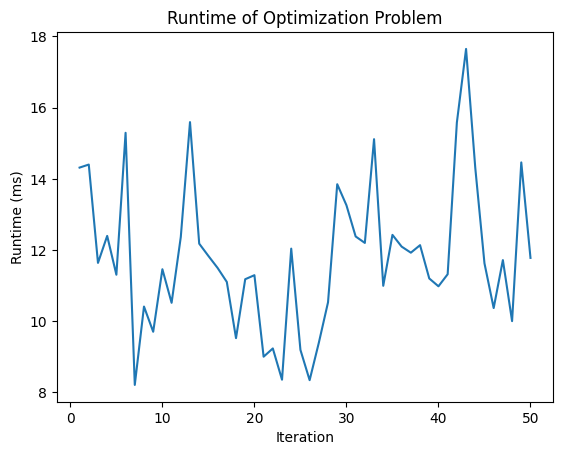

In [ ]:
from pulp import *
import random
import time
import matplotlib.pyplot as plt

# Define the data
M = 50  # Total number of charging stations
G = 1  # Number of EVs

# Random data for EV and CS
EV = {
    'ID': 'EV1',
    'Vs': 50,  # Speed of EV (km/h)
}

# Initialize lists to store runtimes and minimized costs
runtimes = []
minimized_costs = []

# Run the optimization problem 50 times
for _ in range(50):
    # Reset the problem
    problem = LpProblem("Charging Station Selection Problem", LpMinimize)

    # Generate random data for EV and CS
    random.seed()
    EV['SoCcur'] = random.uniform(10, 50)  # Random current state of charge
    EV['SoCdes'] = random.uniform(60, 100)  # Random desired state of charge
    EV['B'] = random.uniform(50, 200)  # Random maximum budget
    EV['alpha'] = random.uniform(5, 15)  # Random charging power at the CS

    CS = {}
    for i in range(1, M+1):
        CS[i] = {
            "ID": f"CS{i}",
            "loc": random.randint(1, 100),
            "Ts": random.randint(0, 12),
            "Te": random.randint(13, 24),
            "Tw": random.randint(10, 20),
            "Cm": random.uniform(1, 2),
            "Cp": random.uniform(1, 2),
            "RCS": random.uniform(1, 10)
        }

    # Define the decision variables
    X = LpVariable.dicts("X", [(g, i) for g in range(1, G+1) for i in range(1, M+1)], cat="Binary")

    # Define the objective function
    Cmon = LpVariable("Cmon")
    Ctra = LpVariable("Ctra")
    Cchar = LpVariable("Cchar")
    Cwait = LpVariable("Cwait")
    C = Cmon + Ctra + Cchar + Cwait
    problem += C

    # Add the constraints
    for g in range(1, G+1):
        problem += lpSum(X[g, i] for i in range(1, M+1)) == 1  # Select exactly one charging station for each EV

    for g in range(1, G+1):
        problem += lpSum(X[g, i] * (CS[i]["Cm"] + CS[i]["Cp"]) for i in range(1, M+1)) <= EV['B']  # Charging monetary cost constraint

    # Define the objective function components
    problem += Cmon == lpSum(X[g, i] * CS[i]["Cm"] for g in range(1, G+1) for i in range(1, M+1))  # Charging monetary cost
    problem += Ctra == EV['Vs'] * lpSum(X[g, i] * CS[i]["loc"] for g in range(1, G+1) for i in range(1, M+1))  # Traveling time cost
    problem += Cchar == 0.1 * ((EV['SoCdes'] - EV['SoCcur']) / EV['alpha'])  # Charging time cost (assuming WC = 0.1)
    problem += Cwait == 0.1 * lpSum(X[g, i] * CS[i]["Tw"] for g in range(1, G+1) for i in range(1, M+1))  # Waiting time cost

    # Solve the problem and measure runtime
    start_time = time.time()
    problem.solve()
    end_time = time.time()

    # Check the status of the solution
    status = LpStatus[problem.status]

    # Store the runtime and minimized cost
    runtime_ms = (end_time - start_time) * 1000  # Convert to milliseconds
    runtimes.append(runtime_ms)
    minimized_costs.append(value(problem.objective))

# Plot the graph of runtime
plt.plot(range(1, 51), runtimes)
plt.xlabel('Iteration')
plt.ylabel('Runtime (ms)')
plt.title('Runtime of Optimization Problem')
plt.show()


# **LOAD AT THE CSes**

EV1 selected 15 with optimization value: 103.03195034
EV2 selected 18 with optimization value: 202.05180968
EV3 selected 10 with optimization value: 202.73346137000001
EV4 selected 17 with optimization value: 102.49919501000001
EV5 selected 15 with optimization value: 251.81367404000002
EV6 selected 16 with optimization value: 552.7981039699999
EV7 selected 3 with optimization value: 601.93526951
EV8 selected 12 with optimization value: 102.08590111999999
EV9 selected 19 with optimization value: 202.08936045
EV10 selected 19 with optimization value: 252.53387786000002
EV11 selected 10 with optimization value: 51.70926984
EV12 selected 13 with optimization value: 302.90220095999996
EV13 selected 4 with optimization value: 101.78403933999999
EV14 selected 19 with optimization value: 52.43903948
EV15 selected 7 with optimization value: 152.09740597
EV16 selected 15 with optimization value: 351.96835080999995
EV17 selected 14 with optimization value: 502.57950157
EV18 selected 18 with opti

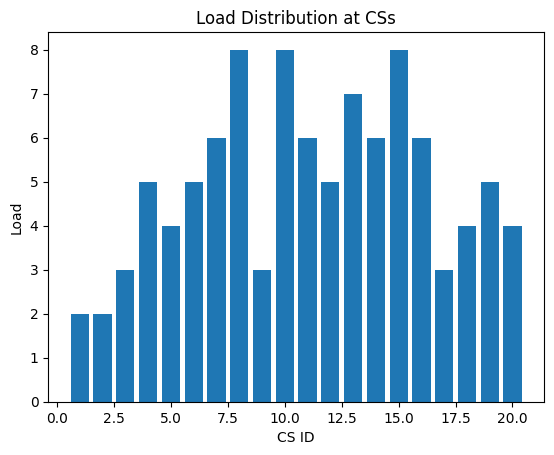

In [ ]:
from pulp import *
import random
import matplotlib.pyplot as plt

# Define the data
G = 100  # Number of EVs
M = 20  # Number of CSs

# Initialize lists to store selected CSs and optimization values for each EV
selected_CSs = []
optimization_values = []

# Solve the optimization problem for each EV
for g in range(1, G + 1):
    # Reset the problem
    problem = LpProblem("Charging Station Selection Problem", LpMinimize)

    # Generate random data for EV
    random.seed(g)  # Set the random seed for EVs using EV index
    EV = {
        'ID': f'EV{g}',
        'Vs': 50,  # Speed of EV (km/h)
        'SoCcur': random.uniform(10, 50),  # Random current state of charge
        'SoCdes': random.uniform(60, 100),  # Random desired state of charge
        'B': random.uniform(50, 200),  # Random maximum budget
        'alpha': random.uniform(5, 15)  # Random charging power at the CS
    }

    # Generate random data for CS
    random.seed(g)  # Set the random seed for CSs using EV index
    CS = {}
    for i in range(1, M + 1):
        CS[i] = {
            "ID": i,
            "loc": random.randint(1, 100),
            "Ts": random.randint(0, 12),
            "Te": random.randint(13, 24),
            "Tw": random.randint(10, 20),
            "Cm": random.uniform(0.1, 0.2),  # Charging cost per kilowatt-hour (kWh)
            "Cp": random.uniform(1, 2),
            "RCS": random.uniform(1, 10)
        }

    # Define the decision variables and objective function
    X = LpVariable.dicts("X", [(g, i) for i in range(1, M + 1)], cat="Binary")
    Cmon = LpVariable("Cmon")
    Ctra = LpVariable("Ctra")
    Cchar = LpVariable("Cchar")
    Cwait = LpVariable("Cwait")
    C = Cmon + Ctra + Cchar + Cwait
    problem += C

    # Add the constraints
    problem += lpSum(X[g, i] for i in range(1, M + 1)) == 1  # Select exactly one charging station for each EV
    problem += lpSum(X[g, i] * (CS[i]["Cm"] + CS[i]["Cp"]) for i in range(1, M + 1)) <= EV['B']  # Charging monetary cost constraint

    # Define the objective function components
    problem += Cmon == lpSum(X[g, i] * CS[i]["Cm"] for i in range(1, M + 1))  # Charging monetary cost
    problem += Ctra == EV['Vs'] * lpSum(X[g, i] * CS[i]["loc"] for i in range(1, M + 1))  # Traveling time cost
    problem += Cchar == 0.1 * ((EV['SoCdes'] - EV['SoCcur']) / EV['alpha'])  # Charging time cost
    problem += Cwait == 0.1 * lpSum(X[g, i] * CS[i]["Tw"] for i in range(1, M + 1))  # Waiting time cost

    # Solve the problem
    problem.solve()

    # Get the selected charging station for the EV
    selected_CS = None
    for i in range(1, M + 1):
        if value(X[g, i]) == 1:
            selected_CS = CS[i]
            break
    selected_CSs.append(selected_CS)

    # Store the optimization value
    optimization_values.append(value(problem.objective))

# Print the selected charging station and optimization value for each EV
for g, selected_CS in enumerate(selected_CSs, start=1):
    print(f"EV{g} selected {selected_CS['ID']} with optimization value: {optimization_values[g-1]}")

# Calculate the load at each CS
load_at_CS = [0] * M
for selected_CS in selected_CSs:
    load_at_CS[selected_CS["ID"] - 1] += 1

# Plot the histogram of load at CSs
plt.bar(range(1, M + 1), load_at_CS)
plt.xlabel('CS ID')
plt.ylabel('Load')
plt.title('Load Distribution at CSs')
plt.show()


### **FINALISED**

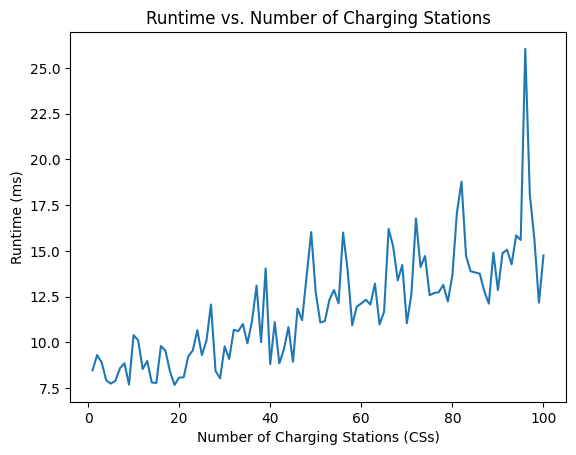

In [ ]:
from pulp import *
import random
import time
import matplotlib.pyplot as plt

# Define the data
G = 1  # Number of EVs
max_num_CS =  100 # Maximum number of charging stations

# Initialize lists to store runtimes and minimized costs
runtimes = []
minimized_costs = []

# Vary the number of charging stations
for M in range(1, max_num_CS + 1):
    # Reset the problem
    problem = LpProblem("Charging Station Selection Problem", LpMinimize)

    # Generate random data for EV and CS
    random.seed()
    EV = {
        'ID': 'EV1',
        'Vs': 50,  # Speed of EV (km/h)
        'SoCcur': random.uniform(10, 50),  # Random current state of charge
        'SoCdes': random.uniform(60, 100),  # Random desired state of charge
        'B': random.uniform(50, 200),  # Random maximum budget
        'alpha': random.uniform(5, 15)  # Random charging power at the CS
    }

    CS = {}
    for i in range(1, M + 1):
        CS[i] = {
            "ID": f"CS{i}",
            "loc": random.randint(1, 100),
            "Ts": random.randint(0, 12),
            "Te": random.randint(13, 24),
            "Tw": random.randint(10, 20),
            "Cm": random.uniform(1, 2),
            "Cp": random.uniform(1, 2),
            "RCS": random.uniform(1, 10)
        }

    # Define the decision variables and objective function
    X = LpVariable.dicts("X", [(g, i) for g in range(1, G + 1) for i in range(1, M + 1)], cat="Binary")
    Cmon = LpVariable("Cmon")
    Ctra = LpVariable("Ctra")
    Cchar = LpVariable("Cchar")
    Cwait = LpVariable("Cwait")
    C = Cmon + Ctra + Cchar + Cwait
    problem += C

    # Add the constraints
    for g in range(1, G + 1):
        problem += lpSum(X[g, i] for i in range(1, M + 1)) == 1  # Select exactly one charging station for each EV

    for g in range(1, G + 1):
        problem += lpSum(X[g, i] * (CS[i]["Cm"] + CS[i]["Cp"]) for i in range(1, M + 1)) <= EV['B']  # Charging monetary cost constraint

    problem += Cmon == lpSum(X[g, i] * CS[i]["Cm"] for g in range(1, G + 1) for i in range(1, M + 1))  # Charging monetary cost
    problem += Ctra == EV['Vs'] * lpSum(X[g, i] * CS[i]["loc"] for g in range(1, G + 1) for i in range(1, M + 1))  # Traveling time cost
    problem += Cchar == 0.1 * ((EV['SoCdes'] - EV['SoCcur']) / EV['alpha'])  # Charging time cost
    problem += Cwait == 0.1 * lpSum(X[g, i] * CS[i]["Tw"] for g in range(1, G + 1) for i in range(1, M + 1))  # Waiting time cost

    # Solve the problem and measure runtime
    start_time = time.time()
    problem.solve()
    end_time = time.time()

    # Check the status of the solution
    status = LpStatus[problem.status]

    # Store the runtime in milliseconds
    runtime_ms = (end_time - start_time) * 1000
    runtimes.append(runtime_ms)

# Plot the graph of runtime vs. number of charging stations
plt.plot(range(1, max_num_CS + 1), runtimes)
plt.xlabel('Number of Charging Stations (CSs)')
plt.ylabel('Runtime (ms)')
plt.title('Runtime vs. Number of Charging Stations')
plt.show()


# **FOR THE PRICE COMPARISION**

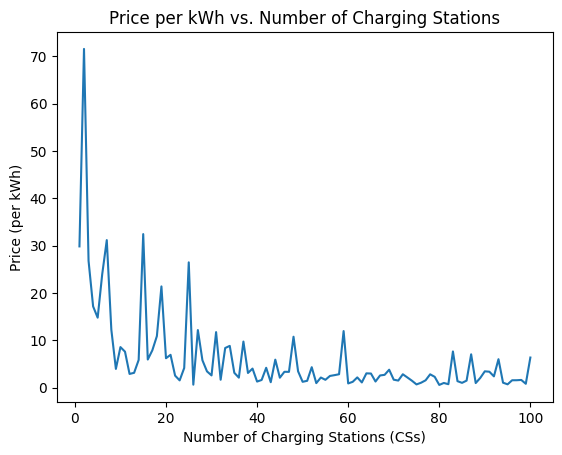

In [ ]:
from pulp import *
import random
import matplotlib.pyplot as plt

# Define the data
G = 1  # Number of EVs
max_num_CS = 100  # Maximum number of charging stations

# Initialize lists to store prices
prices = []

# Vary the number of charging stations
for M in range(1, max_num_CS + 1):
    # Reset the problem
    problem = LpProblem("Charging Station Selection Problem", LpMinimize)

    # Generate random data for EV and CS
    random.seed()
    EV = {
        'ID': 'EV1',
        'Vs': 50,  # Speed of EV (km/h)
        'SoCcur': random.uniform(10, 50),  # Random current state of charge
        'SoCdes': random.uniform(60, 100),  # Random desired state of charge
        'B': random.uniform(50, 200),  # Random maximum budget
        'alpha': random.uniform(5, 15)  # Random charging power at the CS
    }

    CS = {}
    for i in range(1, M + 1):
        CS[i] = {
            "ID": f"CS{i}",
            "loc": random.randint(1, 100),
            "Ts": random.randint(0, 12),
            "Te": random.randint(13, 24),
            "Tw": random.randint(10, 20),
            "Cm": random.uniform(0.1, 0.2),  # Charging cost per kilowatt-hour (kWh)
            "Cp": random.uniform(1, 2),
            "RCS": random.uniform(1, 10)
        }

    # Define the decision variables and objective function
    X = LpVariable.dicts("X", [(g, i) for g in range(1, G + 1) for i in range(1, M + 1)], cat="Binary")
    Cmon = LpVariable("Cmon")
    Ctra = LpVariable("Ctra")
    Cchar = LpVariable("Cchar")
    Cwait = LpVariable("Cwait")
    C = Cmon + Ctra + Cchar + Cwait
    problem += C

    # Add the constraints
    for g in range(1, G + 1):
        problem += lpSum(X[g, i] for i in range(1, M + 1)) == 1  # Select exactly one charging station for each EV

    for g in range(1, G + 1):
        problem += lpSum(X[g, i] * (CS[i]["Cm"] + CS[i]["Cp"]) for i in range(1, M + 1)) <= EV['B']  # Charging monetary cost constraint

    problem += Cmon == lpSum(X[g, i] * CS[i]["Cm"] for g in range(1, G + 1) for i in range(1, M + 1))  # Charging monetary cost
    problem += Ctra == EV['Vs'] * lpSum(X[g, i] * CS[i]["loc"] for g in range(1, G + 1) for i in range(1, M + 1))  # Traveling time cost
    problem += Cchar == 0.1 * ((EV['SoCdes'] - EV['SoCcur']) / EV['alpha'])  # Charging time cost
    problem += Cwait == 0.1 * lpSum(X[g, i] * CS[i]["Tw"] for g in range(1, G + 1) for i in range(1, M + 1))  # Waiting time cost

    # Solve the problem
    problem.solve()

    # Record the price per kilowatt-hour (kWh)
    price_per_kWh = value(problem.objective) / (EV['SoCdes'] - EV['SoCcur'])
    prices.append(price_per_kWh)

# Plot the graph of price per kilowatt-hour (kWh) vs. number of charging stations
plt.plot(range(1, max_num_CS + 1), prices)
plt.xlabel('Number of Charging Stations (CSs)')
plt.ylabel('Price (per kWh)')
plt.title('Price per kWh vs. Number of Charging Stations')
plt.show()


# New Section

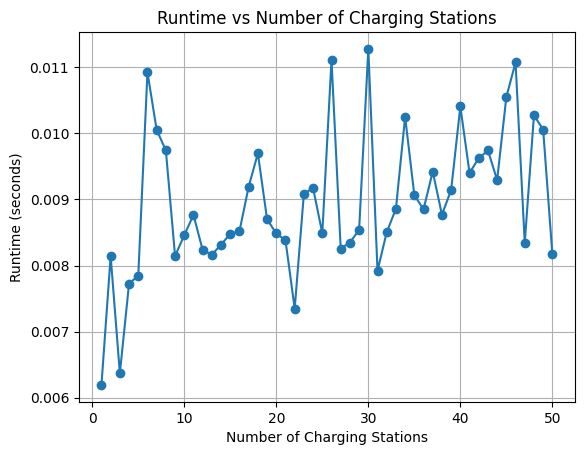

In [ ]:
from pulp import *
import matplotlib.pyplot as plt
import time

# Define the problem
problem = LpProblem("Charging Station Selection Problem", LpMinimize)

# Define the data
G = 1  # Number of EVs
alpha = 10  # Charging power at the CS
WT = Ww = WC = 0.1  # Weight conversion factors
B = 100  # Maximum budget of the EV

# Define the range of CSs
cs_count = 50

# Initialize lists to store the number of CSs and their corresponding runtimes
cs_counts = []
runtimes = []

# Loop over the number of CSs
for cs in range(1, cs_count + 1):

    # Random data for EV
    ev_data = {
        "SOCdes": 50,  # Desired state of charge
        "SOCcur": 20,  # Current state of charge
    }

    # Random data for CSs
    CS = {}
    for i in range(1, cs + 1):
        CS[i] = {
            "ID": f"CS{i}",
            "loc": i * 10,
            "Ts": i % 10,
            "Te": (i % 10) + 10,
            "Tw": 10 + (i % 10),
            "Cm": 1 + (i % 3),
            "Cp": 2 + (i % 2),
            "RC S": 0.5 + (i % 5) * 0.1,
        }

    # Define decision variables
    X = LpVariable.dicts("X", [(g, i) for g in range(1, G + 1) for i in range(1, cs + 1)], cat="Binary")

    # Define objective function
    problem += lpSum(
        X[(g, i)] * (CS[i]["Cm"] + CS[i]["Cp"]) * ((ev_data["SOCdes"] - ev_data["SOCcur"]) / alpha) * WC
        + X[(g, i)] * CS[i]["loc"] * WT
        + X[(g, i)] * CS[i]["Tw"] * Ww
        for g in range(1, G + 1)
        for i in range(1, cs + 1)
    )

    # Define constraints
    for g in range(1, G + 1):
        problem += lpSum(X[(g, i)] for i in range(1, cs + 1)) == 1  # Only one CS can be selected per EV

    for i in range(1, cs + 1):
        problem += lpSum(X[(g, i)] * CS[i]["Cm"] for g in range(1, G + 1)) <= B  # Budget constraint

    # Measure the runtime
    start_time = time.time()
    problem.solve()
    end_time = time.time()
    runtime = end_time - start_time

    # Store the number of CSs and their runtime
    cs_counts.append(cs)
    runtimes.append(runtime)

    # Clear the problem for the next iteration
    problem = LpProblem("Charging Station Selection Problem", LpMinimize)

# Plot the runtime line graph
plt.plot(cs_counts, runtimes, marker="o")
plt.xlabel("Number of Charging Stations")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime vs Number of Charging Stations")
plt.grid(True)
plt.show()



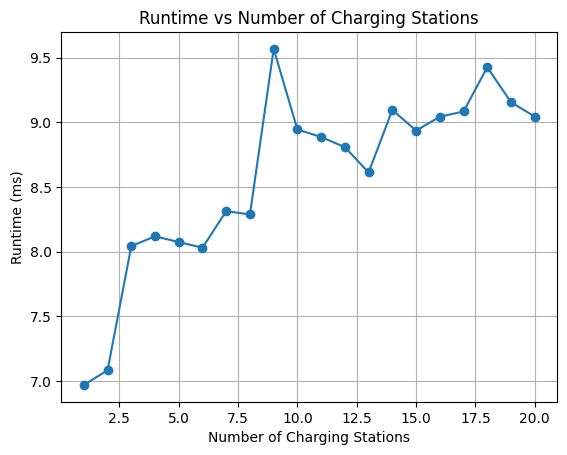

In [ ]:
from pulp import *
import matplotlib.pyplot as plt
import time

# Define the problem
problem = LpProblem("Charging Station Selection Problem", LpMinimize)

# Define the data
G = 1  # Number of EVs
alpha = 10  # Charging power at the CS
WT = Ww = WC = 0.1  # Weight conversion factors
B = 100  # Maximum budget of the EV

# Define the range of CSs
min_cs = 1
max_cs = 20

# Initialize lists to store the number of CSs and their corresponding runtimes
cs_count = []
runtimes = []

# Loop over the number of CSs
for cs in range(min_cs, max_cs + 1):

    # Random data for EV and CS
    SOCdes = 50  # Desired state of charge
    SOCcur = 20  # Current state of charge

    # Random data for CSs
    CS = {}
    for i in range(1, cs + 1):
        CS[i] = {
            "ID": f"CS{i}",
            "loc": i * 10,
            "Ts": i % 10,
            "Te": (i % 10) + 10,
            "Tw": 10 + (i % 10),
            "Cm": 1 + (i % 3),
            "Cp": 2 + (i % 2),
            "RC S": 0.5 + (i % 5) * 0.1,
        }

    # Define decision variables
    X = LpVariable.dicts("X", [(g, i) for g in range(1, G + 1) for i in range(1, cs + 1)], cat="Binary")

    # Define objective function
    problem += lpSum(
        X[(g, i)] * (CS[i]["Cm"] + CS[i]["Cp"]) * ((SOCdes - SOCcur) / alpha) * WC
        + X[(g, i)] * CS[i]["loc"] * WT
        + X[(g, i)] * CS[i]["Tw"] * Ww
        for g in range(1, G + 1)
        for i in range(1, cs + 1)
    )

    # Define constraints
    for g in range(1, G + 1):
        problem += lpSum(X[(g, i)] for i in range(1, cs + 1)) == 1  # Only one CS can be selected per EV

    for i in range(1, cs + 1):
        problem += lpSum(X[(g, i)] * CS[i]["Cm"] for g in range(1, G + 1)) <= B  # Budget constraint

    # Measure the runtime
    start_time = time.time()
    problem.solve()
    end_time = time.time()
    runtime = (end_time - start_time) * 1000  # Convert seconds to milliseconds

    # Store the number of CSs and their runtime
    cs_count.append(cs)
    runtimes.append(runtime)

    # Clear the problem for the next iteration
    problem = LpProblem("Charging Station Selection Problem", LpMinimize)

# Plot the runtime line graph
plt.plot(cs_count, runtimes, marker="o")
plt.xlabel("Number of Charging Stations")
plt.ylabel("Runtime (ms)")
plt.title("Runtime vs Number of Charging Stations")
plt.grid(True)
plt.show()


In [ ]:
pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 54.5 MB/s eta 0:00:00
